Для оптимального выбора модели необходим способ проверки того, что конктретная модель с конкретными гиперпараметрами хорошо апроксимирует данные.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Проверка модели

#### Плохой способ проверки модели

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

In [3]:
# Выбираем классификатор на основе метода k-средних с n_neighbors=1
# Эту модель модно описать фразой - Метка для неизвестной точки такая же как и ближайшая к ней обучающей точки

from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X, y)
y_model = model.predict(X)

# Вычисляем долю правильно маркированных точек
from sklearn.metrics import accuracy_score 
accuracy_score(y, y_model)

1.0

Показатель точности равен 100%, но есть одинс фундаментальный изъян в данной проверке - мы учимся и делаем проверку на одних и тех же данных.

#### Хороший способ проверки данных: отложенные данные

In [4]:
# берем функцию из другого модуля(старая версия cross_validation)
from sklearn.model_selection import train_test_split

# разделяем данные пополам
X1, X2, y1, y2 = train_test_split(X, y, random_state=0, test_size=0.5)

# Обучаем на одном из наборов
model.fit(X1, y1)

# Оцениваем работу модели на другом наборе
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.9066666666666666

Главный недостаток данного метода заключается в том, что мы учили нашу модель только на половине данных.

Один из сопсобов решения этой проблемы - перекрестная проверка.

In [5]:
# Мы выполняем две попытки проверки, попеременно используя каждую половину данных в качестве отложенного набора данных.

y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

# Далее можно взять среднюю от этих цифр

(0.96, 0.9066666666666666)

Этот конктретный вид перекрестной проверки называется двухблочной перекретсной проверкой(Two-fold cross-validation)

Можно распространять эту идею на случай большего числа попыток.

In [6]:
# Разбиваем данные на пять групп и по очереди используем каждую из них для проверки
# Для этого есть удобная утилита cross_val_score, для большей краткости синтаксиса

from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

Библиотека Scikit-learn реализует множество способов перекретсной проверки. Они находятся в модуле model_selection(старый cross_validation)

In [7]:
# Например мы берем предельный случай проверки, когда кол-во блоков равно кол-ву точек в данных.
# Такой тип перекрестной проверки известен под названием
# перекрестной проверки по отдельным объектам(leave-one-out cross-validation)

from sklearn.cross_validation import LeaveOneOut
scores = cross_val_score(model, X, y, cv=LeaveOneOut(len(X)))
scores
# такая оценка дает нам результаты по всем 150 попыткам 

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [8]:
# Среднее значение этих результатов дает нам общую оценку частоты ошибок
scores.mean()

0.96

# Выбор оптимальной модели

Что делать, если наш оцениватель показывает недостаточно хорошие результаты? Существует несколько возможных ответов:
- использовать более сложную/гибкую модель;
- применять менее сложную/гибкую модель;
- собрать больше выборок для обучения;
- собрать больше данных для добавления новых признаков к каждой заданной выборке.

В частности, иногда использование более сложной модели приводит к худшим результатам, а добавление новых выборок не приводит к улучшению.

In [9]:
# Рассмотрим модель полиноминальной регрессии
# В библиотеке Scikit-learn ее можно реализовать с помощью простой линейной регрессии 
# в сочетании с полиноминальным препроцессором. 

# Мы воспользуемся Конвейером(pipeline) для соединения этих операций в единую цепочку

# Конвейер и полиноминальные признаки рассмотрим подробнее позже.

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

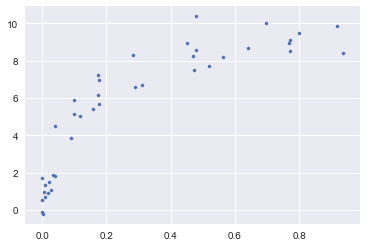

In [10]:
# Создадим данные, на которых будем обучать нашу модель
def make_data(N, err=1.0, rseed=1):
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)
plt.scatter(X, y, s=10);

In [11]:
from sklearn.metrics import r2_score

**R$^2$** - коэффициент детерминации или коэф. смешанной корреляции. Он показывает насколько хорошо работает алгоритм в сравнении с простым средним значением целевых величин.  
**R$^2$ = 1** означает идеальное совпадение,  
**R$^2$ = 0** показывает, что модель оказалась ничем не лучше простого среднего значения данных,  
**R$^2$ < 0** значит модель работает еще хуже.

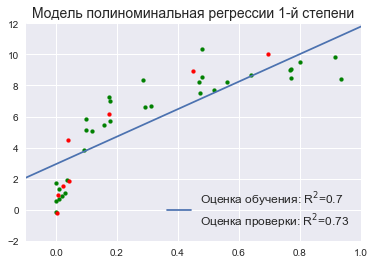

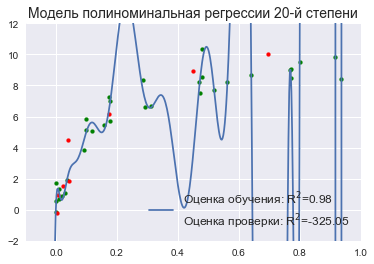

In [12]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]
X1, X2, y1, y2 = train_test_split(X, y, random_state=42, test_size=0.2)

for degree in [1, 20]:
    model = PolynomialRegression(degree).fit(X1, y1)
    
    y_test = model.predict(X_test)
    y_model1 = model.predict(X1)
    y_model2 = model.predict(X2)
    
    r_sc1 = np.round(r2_score(y1, y_model1), 2)
    r_sc2 = np.round(r2_score(y2, y_model2), 2)
    
    plt.figure()
    #plt.scatter(X.ravel(), y, s=15, color='black')
    plt.scatter(X1, y1, s=15, color='green')
    plt.scatter(X2, y2, s=15, color='red')
    plt.plot(X_test.ravel(), y_test,
             label='Оценка обучения: R$^2$={}\nОценка проверки: R$^2$={}'.format(r_sc1, r_sc2))
    plt.xlim(-0.1, 1.0)
    plt.ylim(-2, 12)
    plt.legend(loc='best', fontsize=12)
    plt.title('Модель полиноминальная регрессии {}-й степени'.format(degree), fontsize=14)
    plt.xlabel('')

    Выбор оптимальной модели состоит в поиске наилучшего компромисса между систематической ошибкой(bias) и дисперсией(variance).

    Как мы видим на графиках выше, обе модели не слишком хорошо апроксимируют наши данные, но проблемы в них различны.

    1. Первая модель недообучена т.к. она слишком проста для внутренней структуры данных и не может описать ее достаточно хорошо. У этой модели имеется значительная систематическая ошибка(bias).
    2. Вторая же модель пытается подобрать для наших данных многочлен высокой степени. И в этом случае модель достаточно гибка, чтобы практически идеально соответствовать данными обучающей выборки. Но хотя она и хорошо описываtn обучающую последовательность, ее результат скорее описывает шум в данных, чем внутренние свойства процесса. О подобной модели говорят, что она переобучена. Т.е. гибкость модели такова, что она в конце концов учитывает не только исходное распределние данных, но и случайные ошибки в них. У этой модели имеется высокая дисперсия(vzriance)

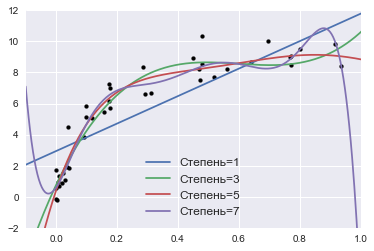

In [13]:
# Визуализируем наши данные вместе с несколькими обученными моделями различных степеней
X_test = np.linspace(-0.1, 1.1, 500)[:, None]
X1, X2, y1, y2 = train_test_split(X, y, random_state=42, test_size=0.2)
plt.scatter(X.ravel(), y, s=15, color='black')
axis = plt.axis()

for degree in [1, 3, 5, 7]:
    y_test = PolynomialRegression(degree).fit(X1, y1).predict(X_test)

    plt.plot(X_test.ravel(), y_test, label='Степень={}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best', fontsize=12);

    Какая же сложность модели дает лучшее приближение к данным? Параметром служащим для управления сложностью модели в данном случае служит степень сногочлена регрессии. Какая же степень обеспечивает подходящий компромисс между систематической ошибкой(недообучение) и высокой дисперсией(переобучение).

## Кривая проверки

    Чтобы решить данный вопрос визуализируем зависимость качества работы модели от ее сложности(в данном случае степени многочлена). Удобно сделать это с помощью утилиты validation_curve. Эта функция получив на вход модель, данные, название парметра и диапазон анализа, автоматически вычисляет в этом диапазоне значение эффектичности обучения и проверки.

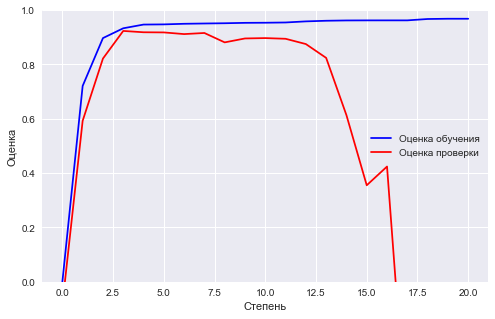

In [14]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree',
                                          degree, cv=7) # получаем семь вариантов на каждую степень
#np.median()
fig = plt.figure(figsize=(8, 5))
# Берем средний(по медиане) из семи вариантов для построения графиков
plt.plot(degree, np.median(train_score, 1), color='blue', label='Оценка обучения')
plt.plot(degree, np.median(val_score, 1), color='red', label='Оценка проверки')

plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('Степень')
plt.ylabel('Оценка');

Показанный на рисунке график называют кривой проверки(Validation curve). Он имеет следующий особенности:
* Оценка эффективности для обучения всегда превышает оценку эффективности для проверки.
* Модели с низкой сложностью(со значительной систематической ошибкой) являются недообучеными, т.е. эти модели будут одинаково плохо предсказывать как данные обучающей выборки, так и любые ранее не виденные ими данные.
* Модели с очень высокой сложностью(с высокой дисперсией) являются переобученными, т.е. будут очень хорошо пресказывать данные обучающей последовательности, но на любых ранее не виденных данных работать очень плохо.
* Кривая проверки достигает максимума в какой-то промежуточной точке. Этот уровень сложности означает приемлемый компромисс между систематической ошибкой и дисперсией.

Средства регулирования сложности зависят от модели.

Судя по графику. Оптимальный компромисс между систематической ошибкой и дисперсией достигается для многочлена третьей степени.

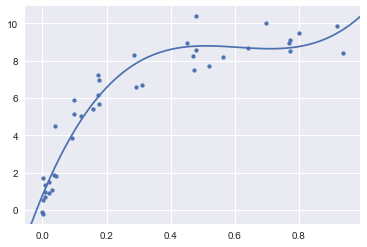

In [15]:
plt.scatter(X.ravel(), y, s=15)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

## Кривые обучения

Важный нюанс выбора сложности модели состоит в том, что оптимальность модели обычно зависит от размера обучающей выборки.

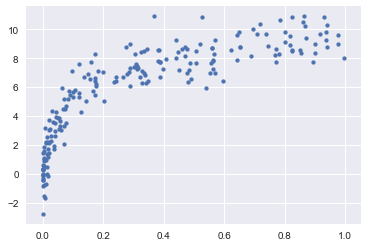

In [16]:
# Например сгенерируем в пять раз больше данных для нашей модели.
X_n, y_n = make_data(200)
plt.scatter(X_n.ravel(), y_n, s=15);

Повторим вышеприведенный код ***Кривой проверки*** для этого большего набора данных, выведя для сравнения предыдущие графики.

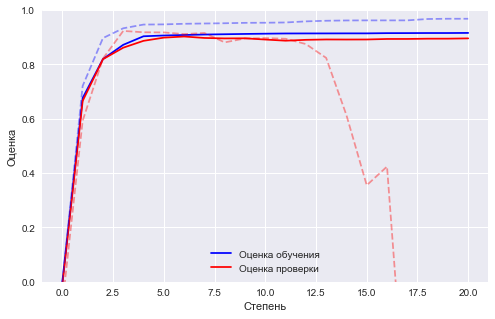

In [17]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X_n, y_n,
                                            'polynomialfeatures__degree',
                                            degree, cv=7)

fig = plt.figure(figsize=(8, 5))

plt.plot(degree, np.median(train_score2, 1), color='blue', label='Оценка обучения')
plt.plot(degree, np.median(val_score2, 1), color='red', label='Оценка проверки')

plt.plot(degree, np.median(train_score, 1), color='blue', linestyle='dashed', alpha=0.4)
plt.plot(degree, np.median(val_score, 1), color='red', linestyle='dashed', alpha=0.4)

plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('Степень')
plt.ylabel('Оценка');

Таким образом, мы видим, что поведение кривой проверки зависит не от одного, а от двух важных факторов: сложности модели и количества точек обучения. Зачастую бывает полезно исследовать поведение модели как функции от количества точек. Сделать это можно путем использования постепенно увеличивающихся подмножеств данных для обучения модели.

Библиотека Scikit-learn предоставляет удобные утилиты для вычисления ***кривых обучения*** для моделей - learning_curve.

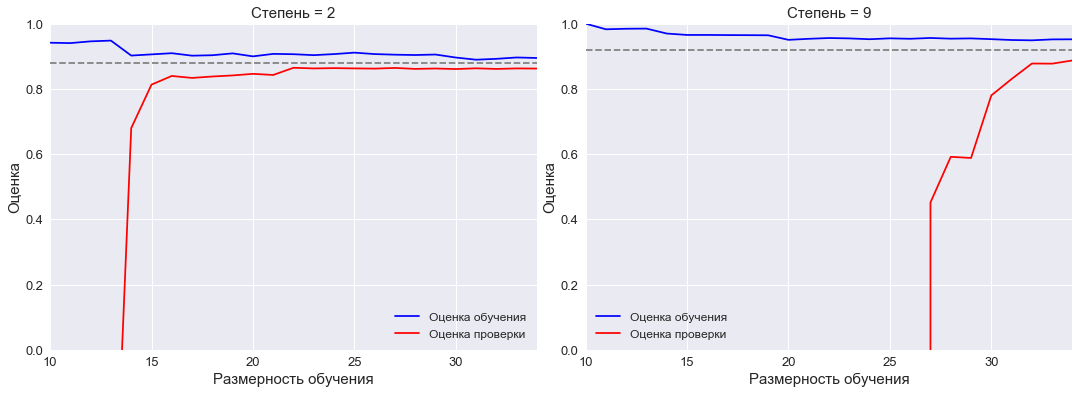

In [19]:
# Вычислим кривую обучения для нашего набора данных второй и девятой степени.
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7, train_sizes=np.linspace(0.3, 1, 25))
    
    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='Оценка обучения')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='Оценка проверки')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1], color='gray', linestyle='dashed')
    
    ax[i].tick_params(labelsize=13)
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('Размерность обучения', size=15)
    ax[i].set_ylabel('Оценка', size=15)
    ax[i].set_title('Степень = {}'.format(degree), size=15)
    ax[i].legend(loc='best', fontsize=12)

Этот показатель демонстрирует как наша модель реагирует на увеличение объема обучающих данных. В частности, после того как кривая обучения уже сошлась к какому-то значению(т.е. когда кривые проверки и обучения уже близки друг к другу), ***добавление дополнительных обучающих данных данных не улучшит аппроксимацию существенно***. Такая ситуация отражена на левом рисунке с кривой обучения для модели второй степени.

Единственный способ улучшения оценки уже сошедшейся кривой - использовать другую(обычно более сложную) модель. Это видно на правом рисунке: перейдя к более сложной модели, мы улучшаем оценку для точки сходимости (отмеченную штриховой линией) за счет более высокой дисперсии модели(соответствующей расстоянию между оценками эффективности для обучения и проверки). Если бы нам пришлось добавить еще больше точек, кривая обучения для более сложной из этих моделей все равно в итоге бы сошлась.

Поведение кривой обучения должно быть следующим:
* Модель заданной сложности окажется **переобученной** на слишком маленьком наборе данных. Это значит, что оценка эффективности для обучения будет относительно высокой, а оценка эффективности для проверки - относительно низкой. *Проверочных данных недостаточно, чтобы модель подстроилась и могла давать приемлемые результаты даже на точкам, которые не видела.*
* Модель заданной сложности окажется **"недообученной"** на слишком большом наборе данных. Это значит, что оценка эффективности для обучения будет снижаться, а оценка эффективности для проверки - повышаться по мере роста размера набора данных. Значит модель все больше будет подстраиваться под общую структуру данных, а не конкретного данного набора.
* Модель никогда, разве что случайно, не покажет на проверочном наборе лучший результат, чем на обучающей последовательности. Это означает, что кривые будут сближаться, но никогда не пересекуться.

## Проверка на практике: поиск по сетке

На практике у моделей обычно больше одного параметра, поэтому графики кривых проверки и обучения превращаются из двумерных линий в многомерные поверхности. Выполнение подобных визуализаций в подобной ситуации представляет собой непростую задачу, поэтому лучше отыскать конкретную модель при которой оценка эффективности достигает максимума.

В библиотеке Scikit-learn есть специальные инструменты содержащиеся в модуле **grid_search**. Рассмотрим трехмерную сетку признаков модели - степень многочлена, флага указывающего нужно ли подбирать точку пересечения с осью ординат, и флага, указывающего следует ли выполнять нормализацию. Выполнить это можно с помощью оценивателя **GridSearchCV**.

In [23]:
from sklearn.grid_search import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)
grid.fit(X, y);

In [31]:
print('лучший результат: ', grid.best_score_)
print('при следующих параметрах:')
grid.best_params_

лучший результат:  0.8956938691106144
при следующих параметрах:


{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

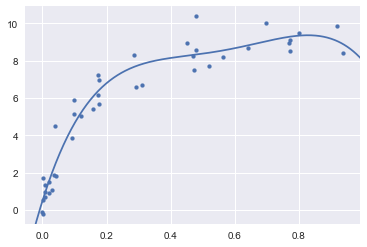

In [36]:
model = grid.best_estimator_

plt.scatter(X, y, s=15)
lim = plt.axis()

y_model = model.fit(X, y).predict(X_test)
plt.plot(X_test, y_model)
plt.axis(lim);

У поиска по сетке множество опций, включая возможности задания пользовательской функции оценки эффективности, распараллеливания вычислений, выполнения случайного поиска и др. Дополнительные примеры в ***Заглянем глубже: ядерная оценка плотности распределения*** и ***Прикладная задача: конвейер распознавания лиц***.

## Проетирование признаков

На вход модели в машинном обучении должны получать матрицы цифр в формате```[n_samples, n_features]```.

### Категориальные признаки 

In [40]:
# Допустим у нас есть данные по ценам на жилье
# и помимо цен и количества комнат у нас есть информация о микрорайоне
data = [
    {'price': 850000, 'rooms': 4, 'neghborhood': 'Queen Anne'},
    {'price': 700000, 'rooms': 3, 'neghborhood': 'Fremont'},
    {'price': 650000, 'rooms': 3, 'neghborhood': 'Wallingford'},
    {'price': 600000, 'rooms': 2, 'neghborhood': 'Fremont'}
       ]

Чтобы привести данные в цифровую форму **не достаточно, просто присвоить каждому району цифру**, т.к. модель машинного обучения будет считать, например, что *Queen Anne < Fremont < Wallingford* или даже *Wallingford - Queen Anne = Fremont*

Испытанным методом для такого случая является **прямое кодирование(one-hot encoding)**, создающее по столбцу индикатору для каждой категории и заполняющую их 1(наличие) или 0(отсутствие). При наличии данных в виде списка словарей можно воспользоваться утилитой DictVectorizer библиотеки Scikit-learn

In [41]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False, dtype=int)
vec.fit_transform(data)

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]], dtype=int32)

neighborhood превратился в три отдельных столбца, отражающих метки микрорайонов. После подобного кодирования можно обучать модель Scikit-learn.

In [42]:
# Чтобы узнать, что означает каждый столбец, можно посмотреть названия признаков:
vec.get_feature_names()

['neghborhood=Fremont',
 'neghborhood=Queen Anne',
 'neghborhood=Wallingford',
 'price',
 'rooms']

У этого подхода есть один недостаток: если количество значений категорий велико, размер набора данных может значеительно вырасти. Однако поскольку кодированные данные состоят в основном из нулей, эфективным будет разреженные формат вывода.

In [43]:
vec = DictVectorizer(sparse=True, dtype=int)
vec.fit_transform(data)

<4x5 sparse matrix of type '<class 'numpy.int32'>'
	with 12 stored elements in Compressed Sparse Row format>

Для поддержки подобного кодирования библиотека Scikit-learn включает две дополниительные утилиты: ***sklearn.preprocessing.OneHotEncoder*** и ***sklearn.feature_extraction.FeatureHasher***

### Текстовые признаки

При проектировании признаков часто требуется преобразовать текст в набор репрзентативных числовых значений. Например один из простейших методов кодирования текста по количеству слов: для каждого фрагмента текста подсчитывается количество вхождений в него каждого из слов. 

In [47]:
# Рассмотрим следующий пример
sample = ['problem of evil',
          'evil queen',
          'horizon problem']

In [49]:
# Простое решение данной задачи в Scikir-learn
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
X = vec.fit_transform(sample)
X

<3x5 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

Результат представляет разреженную матрицу, содержащую количество вхождений каждого из слов.

In [50]:
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

evil  horizon  of  problem  queen
0     1        0   1        1      0
1     1        0   0        0      1
2     0        1   0        1      0

У этого подхода существуют проблемы: использоание непосредственно количества слов ведет к признакам, с которыми встречающимся очень часто словам придается очень большое значение, а это в некоторых алгоритмах классификации оказывается не оптимальным. Один из подходов к решению данной проблемы известен под названием "Терма-обратная частотность документа" или **TF-IDF**. При нем оба слова получают вес с учетом частоты их появления во всех документах.

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform(sample)
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

evil   horizon        of   problem     queen
0  0.517856  0.000000  0.680919  0.517856  0.000000
1  0.605349  0.000000  0.000000  0.000000  0.795961
2  0.000000  0.795961  0.000000  0.605349  0.000000

### Признаки для изображений